<a href="https://colab.research.google.com/github/G0nkly/pytorch_sandbox/blob/main/gpts/DIY_AK_GPT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
##
# LETS DO THE FOLLOWING
# TASK I:
# - download https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
# - load the downloaded data, create a vocab and a tokenization
# - split the dataset into train and test and move it into the pytorch "world"
# - create a get_batch(split) function
# - create a estimate_loss() function (for the loss on train and test)
# - create a Bigram model with a forward(self, x, targets) and generate(self, idx, max_new_tokens) function
# - create a train loop (with evaluation) and extract all hyperparameters into a separate space
# - use the model on some example input
# - common pitfalls: torch device, # of parameters, train loop + eval
#
# TASK II:
# - Create a new model from the Bigram Model and add the following
# -- Positional Encoding
# -- A single attention head
# -- Multiple Attention Heads in parallel
# -- A FeedForward Layer
# -- LayerNormas and Residual Connections


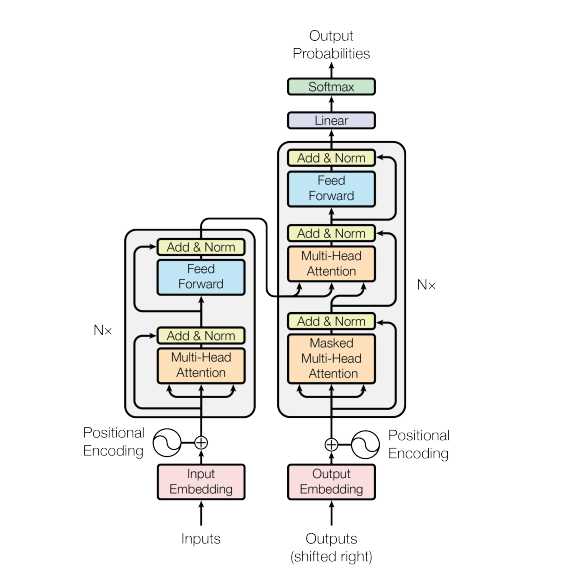

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#####################
# DATASET RETRIEVAL #
#####################

In [ ]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2025-10-19 06:50:11--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.05s   

2025-10-19 06:50:12 (21.6 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [ ]:
with open("input.txt", mode="r") as f:
  text = f.read()

print(text[:10])

First Citi


In [ ]:
###################
# HYPERPARAMETERS #
###################

In [1]:
block_size = 8
batch_size = 32
device = "cuda" if torch.cuda.is_available() else "cpu"
embed_dim = 32
n_epochs = 10
learning_rate = 1e-04
test_epochs = 200
eval_iters = 100
head_size = 8
n_heads = 4
n_blocks = 6

NameError: name 'torch' is not defined

In [ ]:
###############################
# TOKENIZATION AND DATALOADER #
###############################

In [ ]:
vocab = list(sorted(set(text)))
text_to_num = {v:k for k,v in enumerate(vocab)}
num_to_text = {k:v for k,v in enumerate(vocab)}
vocab_size = len(vocab)

In [ ]:
encode = lambda text: [text_to_num[t] for t in text]
decode = lambda numbers: "".join([num_to_text[n] for n in numbers])

In [ ]:
decode(encode("Haubi"))

'Haubi'

In [ ]:
data = torch.tensor(encode(text))
train_idx = int(0.9 * len(data))
train = data[:train_idx]
test = data[train_idx:]
len(train), len(test)

(1003854, 111540)

In [ ]:
def get_batch(split):
  dataset = train if split == "train" else test
  idx = torch.randint(0, len(train) - block_size, (batch_size,))
  X = torch.stack([train[i:i +  block_size] for i in idx])
  Y = torch.stack([train[i + 1: i + block_size + 1] for i in idx])
  X, Y = X.to(device), Y.to(device)

  return X, Y

In [ ]:
X, Y = get_batch("train")
X[1], Y[1]

(tensor([60, 43,  1, 58, 46, 43, 51,  1]),
 tensor([43,  1, 58, 46, 43, 51,  1, 39]))

In [ ]:
@torch.no_grad()
def evaluate_model(model):
  out = {}
  model.eval()
  for split in ["train", "test"]:
    test_loss = torch.zeros(test_epochs)
    for epch in range(test_epochs):
      Xtst_b, Ytst_b = get_batch("test")
      _, loss = model(Xtst_b, Ytst_b)

      test_loss[epch] = loss.item()

    out[split] = test_loss.mean(dim=-1)

  model.train()

  return out

In [ ]:
################
# BUILD MODELS #
################

In [ ]:
class SimpleBiGramModel(nn.Module):

  def __init__(self):
    super().__init__()
    self.emb = nn.Embedding(vocab_size, vocab_size)

  def forward(self, x, targets=None):
    logits = self.emb(x)
    if targets is not None:
      B, T, C = logits.shape
      logits = logits.view(B*T, C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits, targets)
      return logits, loss
    return logits

  def generate(self, start_token, length):
    """
    start_token: (B, 1) tensor with the initial token(s)
    length: how many new tokens to generate
    """
    for _ in range(length):
      # only keep the last token
      input = start_token[:, -block_size:]   # shape (B, 1)

      # forward pass → logits for vocab
      logits = self(input)          # (B, 1, C)

      # take the logits at the last position
      print(logits)
      logits = logits[:, -1, :]     # (B, C)

      # turn into probabilities
      probs = F.softmax(logits, dim=-1)  # (B, C)

      # sample next token for each batch
      next_token = torch.multinomial(probs, num_samples=1)  # (B, 1)

      # append to sequence
      start_token = torch.cat((start_token, next_token), dim=1)

    return start_token


In [ ]:
class AttentionHead(nn.Module):

  def __init__(self, embed_dim, head_size):
    super().__init__()
    self.query = nn.Linear(in_features=embed_dim, out_features=head_size)
    self.key = nn.Linear(in_features=embed_dim, out_features=head_size)
    self.value = nn.Linear(in_features=embed_dim, out_features=head_size)
    self.register_buffer("tril", torch.tril(torch.ones((block_size, block_size))))


  def forward(self, x):
    B, T, C = x.shape
    query = self.query(x)
    key = self.key(x)
    value = self.value(x)
    weights = query @ torch.transpose(key, 1, -1)
    weihgts = weights / (embed_dim)**0.5
    weights = weights.masked_fill_(self.tril[:T, :T] == 0, float("-inf"))
    weights = F.softmax(weights, dim=-1)
    weights = weights @ value

    return weights



In [ ]:
class FeedForward(nn.Module):

  def __init__(self):
    super().__init__()
    self.ff_layer = nn.Sequential(
        nn.Linear(embed_dim, 4 * embed_dim),
        nn.ReLU(),
        nn.Linear(4 * embed_dim, embed_dim)
    )

  def forward(self, x):
    x = self.ff_layer(x)

    return x

In [ ]:
class MultiHeadAttention(nn.Module):

  def __init__(self):
    super().__init__()
    self.attention_heads = nn.ModuleList([AttentionHead(embed_dim, head_size) for _ in range(n_heads)])
    self.projection = nn.Linear(embed_dim, embed_dim)

  def forward(self, x):
    B, T, C = x.shape
    x = torch.cat([head(x) for head in self.attention_heads], dim=-1)
    x = self.projection(x)

    return x

In [ ]:
class AttentionBlock(nn.Module):

  def __init__(self):
    super().__init__()
    self.mhsa = MultiHeadAttention()
    self.ff = FeedForward()
    self.layer_norm1 = nn.LayerNorm(embed_dim)
    self.layer_norm2 = nn.LayerNorm(embed_dim)

  def forward(self, x):
    x = x + self.mhsa(self.layer_norm1(x))
    x = x + self.ff(self.layer_norm2(x))

    return x


In [ ]:
class MyBelovedTransformer(nn.Module):

  def __init__(self):
    super().__init__()
    self.tok_embd = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim)
    self.pos_embd = nn.Embedding(num_embeddings=block_size, embedding_dim=embed_dim)
    self.attention_blocks = nn.ModuleList([AttentionBlock() for _ in range(n_blocks)])
    self.nn_head = nn.Linear(in_features=embed_dim, out_features=vocab_size)

  def forward(self, x, targets=None):
    x = self.tok_embd(x) # B, T, C
    _, T, _ = x.shape
    x = x + self.pos_embd(torch.arange(start=0, end=T))
    for block in self.attention_blocks:
      x = block(x)
    logits = self.nn_head(x)
    if targets is None:
      return logits
    else:
      B, _, C = logits.shape
      logits = logits.view(B*T, C) # B*T, C
      targets = targets.view(B*T) # B*T
      loss = F.cross_entropy(logits, targets)
      return logits, loss

  def generate(self, start_sequence, num_tokens):
    for _ in range(num_tokens):

      x = start_sequence[:, -block_size:] # B, block_size
      logits = self(x) # B, block_size, C
      logits = logits[:, -1, :] # B, 1, C
      probs = F.softmax(logits, dim=-1)
      idx_next = torch.multinomial(probs, num_samples=1) # B, 1
      start_sequence = torch.cat((start_sequence, idx_next), dim=-1) # B, T + 1

    return start_sequence

In [ ]:
model = MyBelovedTransformer()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(10000):

  if epoch % eval_iters == 0 or epoch == n_epochs - 1:
    out = evaluate_model(model)
    print(f"Epoch: {epoch}, train loss: {out["train"]:.4f}, test loss: {out["test"]:.4f}")

  X_batch, Y_batch = get_batch("train")
  logits, loss = model(X_batch, Y_batch)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  X_test_batch, Y_test_batch = get_batch("test")
  _, test_loss = model(X_test_batch, Y_test_batch)



Epoch: 0, train loss: 2.3342, test loss: 2.3514
Epoch: 9, train loss: 2.3532, test loss: 2.3442
Epoch: 100, train loss: 2.3458, test loss: 2.3390
Epoch: 200, train loss: 2.3529, test loss: 2.3465
Epoch: 300, train loss: 2.3303, test loss: 2.3320
Epoch: 400, train loss: 2.3420, test loss: 2.3369
Epoch: 500, train loss: 2.3427, test loss: 2.3458
Epoch: 600, train loss: 2.3272, test loss: 2.3299
Epoch: 700, train loss: 2.3273, test loss: 2.3440
Epoch: 800, train loss: 2.3297, test loss: 2.3384
Epoch: 900, train loss: 2.3316, test loss: 2.3403
Epoch: 1000, train loss: 2.3218, test loss: 2.3261
Epoch: 1100, train loss: 2.3351, test loss: 2.3252
Epoch: 1200, train loss: 2.3212, test loss: 2.3243
Epoch: 1300, train loss: 2.3165, test loss: 2.3326
Epoch: 1400, train loss: 2.3232, test loss: 2.3226
Epoch: 1500, train loss: 2.3223, test loss: 2.3170
Epoch: 1600, train loss: 2.3264, test loss: 2.3311
Epoch: 1700, train loss: 2.3288, test loss: 2.3247
Epoch: 1800, train loss: 2.3128, test loss: 2.

In [ ]:
generated_output = model.generate(torch.randint(0, 65, (1, 8)), 300)
output_list = generated_output.view(-1).tolist()
"".join([decode(output_list)])

"xi:UhaCh atinffolf fout cly be.\n\nOBORCOMIUS:\nI'w, wardig hom cat fill\nTo hat olll acemy worded!\nBawn to and day fur in amath\nCife last ror dut be the wit sinest as thy yow hiryf in he ougt in warweld thot mocosw be fefncyesory wafr furdaink and Is nom wilt toudst, bre me in the hiemm been.\nSend hen onis cnd"

In [ ]:
################
# SAVE STATION #
################

In [ ]:
save_path = '/content/drive/MyDrive/model_1_mhsa.pth'
torch.save(model.state_dict(), save_path)

In [ ]:
################
# LOAD STATION #
################

In [ ]:
model.load_state_dict(torch.load(save_path))
model.eval()

MyBelovedTransformer(
  (tok_embd): Embedding(65, 32)
  (pos_embd): Embedding(8, 32)
  (attention_head): AttentionHead(
    (query): Linear(in_features=32, out_features=32, bias=True)
    (key): Linear(in_features=32, out_features=32, bias=True)
    (value): Linear(in_features=32, out_features=32, bias=True)
  )
  (nn_head): Linear(in_features=32, out_features=65, bias=True)
)

In [ ]:
##############
# PLAYGROUND #
##############

In [ ]:
start_tensor = torch.randint(0, 65, size=(1, 8))
tok_embedding = nn.Embedding(65, 32)
pos_embedding = nn.Embedding(8, 32)
query = nn.Linear(32, 32)
nn_head = nn.Linear(32, 65)

x = tok_embedding(start_tensor)
x = x + pos_embedding(torch.arange(0, 8))
x = query(x)
x.shape
#logits = nn_head(x)


#logits.shape


torch.Size([1, 8, 32])